<a href="https://colab.research.google.com/github/lucas-azdias/Artistic-Text-Recognition/blob/main/artefatos/TCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configurações

## Importações

In [718]:
import abc
import collections
import dataclasses
import json
import math
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.ticker as mpticker
import matplotlib_venn as venn
import numpy as np
import pathlib
import PIL
import re
import statistics
import string
import sys
import tqdm
import typing

### Configuração do MatPlotLib

#### Configuração da fonte

In [443]:
# Fonte
plt.rcParams["font.size"] = 20
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["DejaVu Serif"]

#### Configuração do LaTeX

In [645]:
# LaTeX
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{color}\usepackage{amsmath}"
plt.rcParams["pgf.texsystem"] = "pdflatex"
plt.rcParams["pgf.preamble"] = r"\usepackage{color}\usepackage{amsmath}"

In [427]:
!apt-get update > /dev/null 2>&1
!apt-get install -y texlive-latex-recommended dvipng texlive-latex-extra texlive-fonts-recommended texlive-xetex texlive-plain-generic > /dev/null 2>&1
!wget -q -O type1cm.zip http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip
!unzip -q -o type1cm.zip
!cd type1cm && latex type1cm.ins > /dev/null 2>&1
!mkdir -p /usr/share/texmf/tex/latex/type1cm
!cp -f type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm
!texhash > /dev/null 2>&1
!apt install -y cm-super > /dev/null 2>&1
!rm -f type1cm.zip
!rm -rf type1cm

## Instalando Miniconda

In [ ]:
!wget -q -O Miniconda.sh https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
!bash Miniconda.sh -b -f -p miniconda > /dev/null
!rm Miniconda.sh

!sudo rm -f /usr/local/bin/conda
!ln -s /content/miniconda/bin/conda /usr/local/bin/conda

!conda tos accept --override-channels --channel https://repo.anaconda.com/pkgs/main
!conda tos accept --override-channels --channel https://repo.anaconda.com/pkgs/r

accepted Terms of Service for https://repo.anaconda.com/pkgs/main
accepted Terms of Service for https://repo.anaconda.com/pkgs/r


## Componentes auxiliares

### Classes auxiliares

In [356]:
# Classe para resultados parciais de predições
@dataclasses.dataclass
class RawPrediction:
    path: pathlib.Path
    pred: str
    confidence: tuple[float, ...]

    def __setattr__(self, name: str, value: typing.Any) -> None:
        if name == "pred" and value:
            value = RawPrediction.normalize(str(value))
        super().__setattr__(name, value)

    def normalize(s: str) -> str:
        return re.sub(r"[^a-z0-9]", "", s.lower()) # Ignora capitalização das letras e símbolos

In [357]:
# Classe para resultados completos de predições
@dataclasses.dataclass
class Prediction(RawPrediction):
    true: str

    def __setattr__(self, name: str, value: typing.Any) -> None:
        if name == "true" and value:
            value = Prediction.normalize(str(value))
        super().__setattr__(name, value)

    def eval(self) -> bool:
        return self.pred == self.true

In [358]:
# Classe para resultados de predições de um modelo
@dataclasses.dataclass
class EnsembleModelPrediction:
    pred: str
    confidence: tuple[float, ...]

In [359]:
# Classe para resultados de predições de vários modelos
@dataclasses.dataclass(kw_only=True)
class EnsemblePrediction(Prediction):
    models_preds: list[EnsembleModelPrediction]
    path: pathlib.Path
    true: str
    pred: typing.Optional[str] = None
    confidence: typing.Optional[tuple[float, ...]] = None

In [360]:
# Classe para itens no dataset
@dataclasses.dataclass
class DatasetItem:
    path: pathlib.Path
    label: str

In [361]:
# Classe para criar ambiente Conda e rodar comandos passados
class CondaEnv:
    def __init__(self, name: str, python_version: str, config_cmds: list[str], path: typing.Optional[pathlib.Path] = None) -> None:
        self.__name = name
        self.__python_version = python_version

        # Caso haja caminho, substitua ele nos comandos
        if path:
            config_cmds = [
                config_cmd.replace("{}", str(path.absolute()))
                for config_cmd in config_cmds
            ]

        # Cria ambiente
        !conda env remove -n "{self.name}" -y -q > /dev/null 2>&1
        !conda create -n "{self.name}" python={python_version} -y -q > /dev/null 2>&1

        # Roda comandos de configuração
        for config_cmd in config_cmds:
            !conda run -n "{self.name}" {config_cmd} > /dev/null 2>&1

    @property
    def name(self) -> str:
        return self.__name

    @property
    def python_version(self) -> str:
        return self.__python_version

    # Função para executar um comando dentro de um ambiente Conda
    def run(self, cmd: str, cd: typing.Optional[str | pathlib.Path] = None, ignore_output: bool = False) -> None:
        !cd {cd if cd else "."} && conda run -n "{self.name}" {cmd}{" > /dev/null 2>&1" if ignore_output else ""}

In [362]:
# Classe para repositórios
class Repo:
    def __init__(self, url: str, path: pathlib.Path) -> None:
        self.__url = url
        self.__path = path

        # Obtém repositório
        pull_repo(self.url, self.path)

    @property
    def url(self) -> str:
        return self.__url

    @property
    def path(self) -> pathlib.Path:
        return self.__path

In [363]:
# Classe para criar modelos
class Model(abc.ABC):
    def __init__(
            self,
            name: str,
            conda_env: CondaEnv,
            repo: Repo,
            should_use_tuned: bool = False,
            output_dir: pathlib.Path = pathlib.Path("output")
        ) -> None:
        self.__name = name
        self.__should_use_tuned = should_use_tuned
        self.__conda_env = conda_env
        self.__repo = repo

        if not output_dir.exists():
            output_dir.mkdir(parents=True)

        if not output_dir.is_dir():
            raise Exception(f"Caminho não corresponde a um diretório: {output_dir}")

        self.__output_dir = output_dir

    @property
    def name(self) -> str:
        return self.__name

    @property
    def should_use_tuned(self) -> bool:
        return self.__should_use_tuned

    @property
    def path(self) -> pathlib.Path:
        return self.__repo.path

    @property
    def output_dir(self) -> pathlib.Path:
        return self.__output_dir

    def pretrained_weights(self) -> str:
        return str((pretrained_path / f"{self.name.lower()}").absolute())

    def tuned_weights(self) -> str:
        return str((tuned_path / f"{self.name.lower()}").absolute())

    def run(self, cmd: str, cd: typing.Optional[str | pathlib.Path] = None, ignore_output: bool = False) -> None:
        self.__conda_env.run(cmd, cd, ignore_output)

    @abc.abstractmethod
    def infer(self, imgs_path: pathlib.Path, dataset_items: list[DatasetItem], verbose: bool = False, should_output: bool = False) -> list[Prediction]:
        pass

In [364]:
# Classe para estratégias do ensemble
class EnsembleStrategy:
    def __init__(
          self,
          strategy: typing.Callable[[EnsemblePrediction], EnsemblePrediction],
          filters: list[typing.Callable[[EnsemblePrediction], bool]] = []
        ) -> None:
        self.__strategy = strategy
        self.__filters = filters

    def __repr__(self) -> str:
        filters_len = len(self.__filters)
        filters_text = (f" ({filters_len} filtro{'s' if filters_len > 1 else ''})" if self.__filters else "")
        return f"{self.__strategy.__name__}" + filters_text

    def __str__(self) -> str:
        return self.__repr__()

    def __call__(self, models_prediction: EnsemblePrediction) -> EnsemblePrediction:
        for filter in self.__filters:
            if not filter(models_prediction):
                return models_prediction
        return self.__strategy(models_prediction)

### Funções auxiliares

In [365]:
# Função para reiniciar caminho
def reset_path(path: pathlib.Path) -> None:
    !rm -rf "{path}"
    !mkdir -p "{path}"

In [366]:
# Função para obter repositório
def pull_repo(url: str, path: pathlib.Path) -> None:
    # Clonar o repositório
    !rm -rf "{path}"
    !git clone -q "{url}" "{path}"

    if not str(path.absolute()) in sys.path:
        sys.path.append(str(path.absolute()))

In [367]:
# Função para alterar trechos dos arquivos alvos
def modify_target_files(target_files: list[pathlib.Path], old_texts: list[str], new_texts: list[str]) -> None:
    for target_file in target_files:
        text = target_file.read_text(encoding="utf-8")

        for old_text, new_text in zip(old_texts, new_texts):
            text = text.replace(
                old_text,
                new_text
            )

        target_file.write_text(text, encoding="utf-8")

In [368]:
# Função para definir nome do arquivo com resultados
def get_results_name(name: str) -> str:
    path_name = name.lower().replace(" ", "_")
    return f"{path_name}_preds.json"

In [369]:
# Função para escrever arquivo com resultados
def write_results(
        path: pathlib.Path,
        results: list[Prediction]
    ) -> None:
    data = []
    for result in results:
        data.append({
            "path": result.path,
            "true": result.true,
            "pred": result.pred,
            "confidence": result.confidence
        })

    with open(path, "w") as file:
        json.dump(data, file, indent = 4, default = str)

In [370]:
# Função para ler os resultados do arquivo
def read_results(
    path: pathlib.Path
) -> list[Prediction]:
    # Verifica se o arquivo existe
    if not path.exists():
        raise FileNotFoundError(f"O arquivo {path} não foi encontrado.")

    # Abre e carrega o conteúdo JSON
    with open(path, "r") as file:
        data = json.load(file)

    # Recupera os dados
    results: list[Prediction] = []
    for item in data:
        results.append(Prediction(
            path = pathlib.Path(item["path"]),
            true = item["true"],
            pred = item["pred"],
            confidence = item["confidence"]
        ))

    return results

In [371]:
# Função para formatar uma coleção de predições
def format_raw_results(raw_results: list[RawPrediction], dataset_items: list[DatasetItem]) -> list[Prediction]:
    results: list[Prediction] = []
    for dataset_item in dataset_items:
        for raw_prediction in raw_results:
            if dataset_item.path.stem == raw_prediction.path.stem:
                results.append(Prediction(
                    path = raw_prediction.path,
                    true = dataset_item.label,
                    pred = raw_prediction.pred,
                    confidence = raw_prediction.confidence
                ))
                break

    return results

In [372]:
# Função para criar função preenchendo parâmetros faltantes
def build_function(name: str, function: typing.Callable, *params: typing.Any) -> typing.Callable:
    func = lambda x: function(x, *params)
    func.__name__ = f"{name}_{function.__name__}"
    return func

In [373]:
# Função para imprimir WRA das predições
def print_wra(name: str, preds: list[Prediction]) -> None:
    total = len(preds)
    correct = sum(1 for item in preds if item.eval())
    wra = correct / total if total > 0 else 0

    print(f"{name}: {wra:.2%} ({correct}/{total})")

In [374]:
# Função para definir caminho das imagens e itens do dataset de acordo com a partição do dataset
def define_inference(dataset_partition: str) -> tuple[pathlib.Path, list[DatasetItem]]:
    imgs = dataset_path / dataset_partition / "images"
    items = dataset_items[dataset_partition]
    return imgs, items

## Obtendo *dataset*

### Obtendo repositório

In [ ]:
# Obtendo repositório
dataset_path = pathlib.Path("/content/WordArt-V1.5")

pull_repo(
    "https://github.com/lucas-azdias/Artistic-Text-Recognition-Dataset.git",
    dataset_path
)

### Carregando partições do *dataset*

In [ ]:
# Lista todos as partições de datasets
dataset_names = [p.name for p in dataset_path.iterdir() if p.is_dir() and not p.name in [".git", "utils"]]

print(dataset_names)

['train', 'testB', 'testA']


In [ ]:
def load_data(base_path: pathlib.Path, name: str) -> tuple[list[pathlib.Path], list[str]]:
    labels_path = pathlib.Path(base_path, name, "labels.txt")

    image_paths = []
    classes = []

    with open(labels_path, "r") as f:
        for line in f:
            # Ex: "train_image\320.png Ford"
            splitted = line.strip().split(" ")
            path, label = splitted[0].replace("\\", "/"), " ".join(splitted[1:])

            # Ajustar o caminho para apontar para a pasta correta
            img_path = pathlib.Path(base_path, name, pathlib.Path(path))
            image_paths.append(img_path)
            classes.append(label)

    return image_paths, classes

In [ ]:
dataset_items: dict[str, list[DatasetItem]] = {}

for dataset_name in dataset_names:
    images, labels = load_data(dataset_path, dataset_name)
    dataset_items[dataset_name] = [
        DatasetItem(
            path=image,
            label=label
        )
        for image, label in zip(images, labels)
    ]

### Visualização do *dataset*

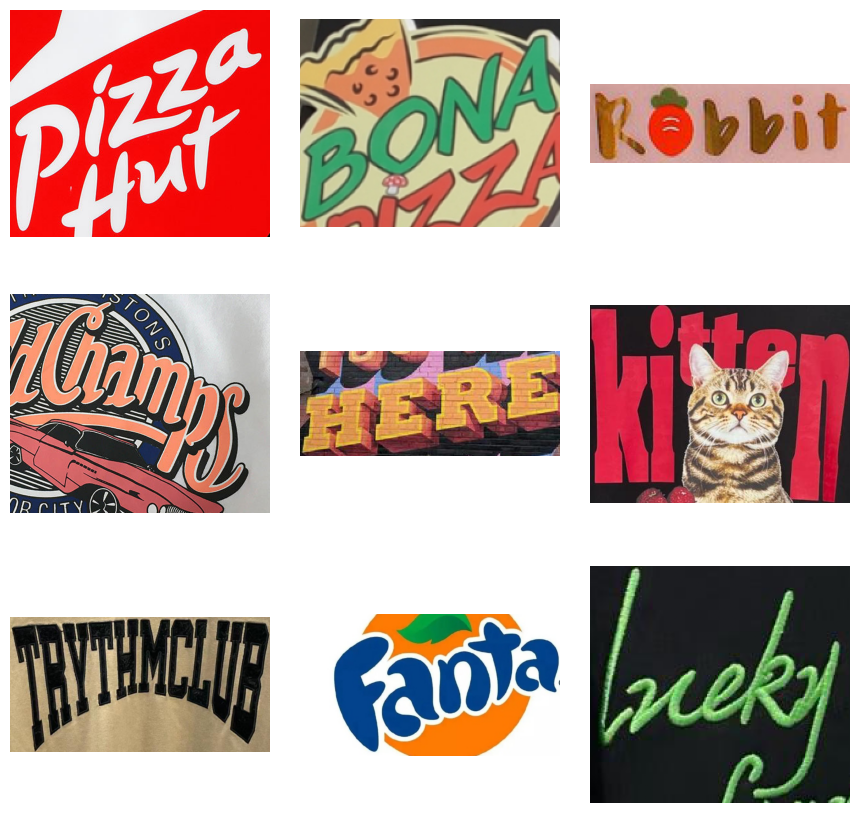

In [446]:
# Imagens a serem exibidas
pictures = [
    "new6381.png",
    "new213.png",
    "new11211.png",
    "new613.png",
    "new808.png",
    "new241.png",
    "new680.png",
    "new55.png",
    "new820.png",
]

# Procura imagens
img_paths = []
for picture in pictures:
    for path in dataset_path.rglob("*.png"):
        if picture == path.name:
            img_paths.append(path)

# Carrega as imagens
images = [mpimg.imread(path) for path in img_paths]

# Cria grade 3x3
fig, axes = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
    for j in range(3):
        img_index = i * 3 + j
        axes[i, j].imshow(images[img_index])
        axes[i, j].axis("off")

plt.tight_layout()
plt.savefig("dataset-examples.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
plt.show()

### Análise do *dataset*

In [474]:
labels = [
    item.label
    for dataset_name in dataset_names
    for item in dataset_items[dataset_name]
]

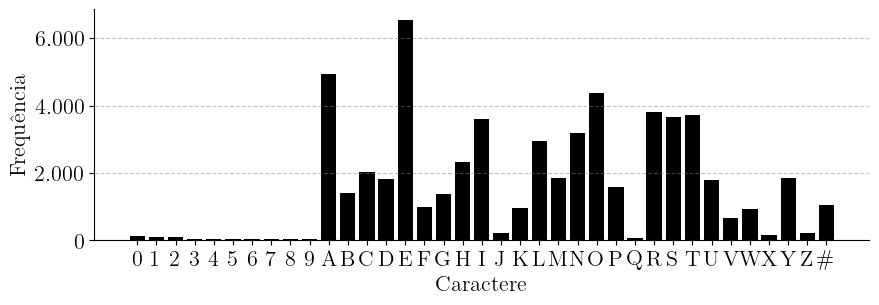

In [475]:
# Combina todos os rótulos em uma única string e normaliza para maiúsculas
text = "".join(labels).upper()

# Substitui símbolos não alfabéticos por "#"
symbol_char = r"\#"
processed = [ch if ch in string.ascii_uppercase or ch.isdigit() else symbol_char for ch in text]

# Conta as frequências de cada caractere
char_counts = collections.Counter(processed)

# Ordena alfabeticamente, deixando "#" por último
chars = sorted([c for c in char_counts if c != symbol_char]) + ([symbol_char] if symbol_char in char_counts else [])
counts = [char_counts[c] for c in chars]

# Gera o gráfico
plt.figure(figsize = (10, 3))
plt.bar(chars, counts, color = "black")
plt.xlabel("Caractere", color = "black", fontsize = 16)
plt.ylabel("Frequência", color = "black", fontsize = 16)
plt.xticks(fontsize = 16, color = "black")
plt.yticks(fontsize = 16, color = "black")
plt.gca().yaxis.set_major_formatter(mpticker.FuncFormatter(lambda x, pos: f"{int(x):,}".replace(",", ".")))
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.grid(axis = "y", linestyle = "--", color = "gray", alpha = 0.5)
plt.tick_params(colors = "black")
plt.savefig("dataset-char-frequency.pdf", format = "pdf", bbox_inches = "tight", pad_inches = 0)
plt.show()

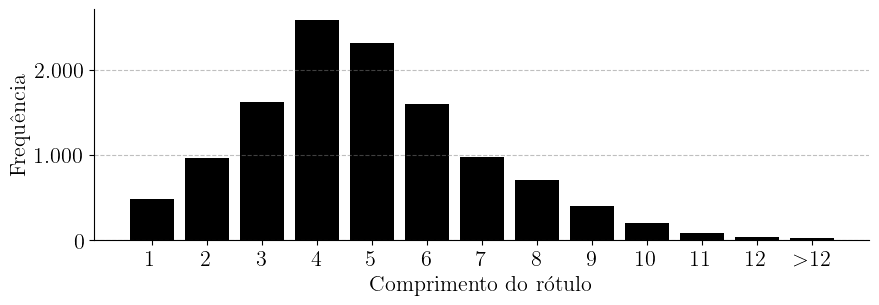

In [476]:
# Compute label lengths with special class for ">12"
max_char = r"$>$12"
processed_lengths = [len(label) if len(label) <= 12 else max_char for label in labels]

# Count frequencies
length_counts = collections.Counter(processed_lengths)

# Sort lengths (numeric first, then ">12" if present)
numeric_lengths = sorted([l for l in length_counts.keys() if isinstance(l, int)])
lengths = numeric_lengths + ( [max_char] if max_char in length_counts else [] )
counts = [length_counts[l] for l in lengths]

# Plot
plt.figure(figsize = (10, 3))
plt.bar([str(l) for l in lengths], counts, color = "black")
plt.xlabel("Comprimento do rótulo", color = "black", fontsize = 16)
plt.ylabel("Frequência", color = "black", fontsize = 16)
plt.xticks(fontsize = 16, color = "black")
plt.yticks(fontsize = 16, color = "black")
plt.gca().yaxis.set_major_formatter(mpticker.FuncFormatter(lambda x, pos: f"{int(x):,}".replace(",", ".")))
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.grid(axis = "y", linestyle = "--", color = "gray", alpha = 0.5)
plt.tick_params(colors = "black")
plt.savefig("dataset-length-frequency.pdf", format = "pdf", bbox_inches = "tight", pad_inches = 0)
plt.show()

In [477]:
# Count labels with 9 or more characters
count = sum(1 for l in labels if len(l) >= 9)
print(f"Quantidade de rótulos com 9 ou mais caracteres: {count}")

Quantidade de rótulos com 9 ou mais caracteres: 754


## Obtendo os modelos

### Caminhos para pesos dos modelos

In [ ]:
# Pesos pré-treinados
pretrained_path = pathlib.Path("/content/weights/pretrained")
reset_path(pretrained_path)

In [ ]:
# Pesos com fine-tuning
tuned_path = pathlib.Path("/content/weights/tuned")
reset_path(tuned_path)

### PARSeq

In [376]:
# Classe do modelo PARSeq
class ParseqModel(Model):
    def pretrained_weights(self) -> str:
        return "pretrained=parseq"

    def tuned_weights(self) -> str:
        return super().tuned_weights() + ".ckpt"

    def infer(self, imgs_path: pathlib.Path, dataset_items: list[DatasetItem], verbose: bool = False, should_output: bool = False) -> list[Prediction]:
        self.run(
            cmd=f"python \"{self.path}/read.py\" \
            {self.tuned_weights() if self.should_use_tuned else self.pretrained_weights()} \
            --images=\"{imgs_path}\" \
            --device=cuda",
            cd=self.path,
            ignore_output=True
        )

        with open(f"{self.path}/outputs.txt") as file:
            raw_results = file.read().strip().split("\n")

        raw_results = [line.strip().split("\t") for line in raw_results]
        raw_results = [
            RawPrediction(
                path=pathlib.Path(path),
                pred=pred,
                confidence=tuple([
                    float(c)
                    for c in confidence.replace("[", "").replace("]", "").strip().split(", ")
                ])
            )
            for path, pred, confidence in raw_results
        ]

        results = format_raw_results(raw_results, dataset_items)

        if should_output:
            write_results(self.output_dir / get_results_name(self.name), results)

        if verbose:
            print_wra(self.name, results)

        return results

In [ ]:
parseq_repo = Repo(
    url = "https://github.com/baudm/parseq.git",
    path = pathlib.Path("/content/parseq")
)

In [ ]:
parseq_env = CondaEnv(
    name = "parseq",
    python_version = "3.10",
    config_cmds = [
        "pip install pip-tools",
        "make torch-cu121 -C {}",
        "pip install -qq -r \"{}/requirements/core.cu121.txt\" -e {}/.[bench,train,test] --use-pep517",
    ],
    path = parseq_repo.path
)

In [400]:
parseq_model = ParseqModel(
    name = "PARSeq",
    conda_env = parseq_env,
    repo = parseq_repo,
    output_dir = pathlib.Path("output/models")
)

In [401]:
tuned_parseq_model = ParseqModel(
    name = "PARSeq",
    conda_env = parseq_env,
    repo = parseq_repo,
    should_use_tuned = True,
    output_dir = pathlib.Path("output/models")
)

In [ ]:
# Modificando trechos necessários
modify_target_files(
    [
        parseq_model.path / "read.py",
    ],
    [
        "import argparse",
        "nargs='+', ",
        "for fname in args.images:",
        "Image.open(fname)",
        "print(f'{fname}: {pred[0]}')",
    ],
    [
        "import argparse\nfrom pathlib import Path",
        "",
        "text = \"\"\n    imgs = Path(args.images)\n    for fname in (imgs.rglob(\"*\") if imgs.is_dir() else [imgs]):",
        "Image.open(fname.absolute())",
        "text += f\"{fname}\t{pred[0]}\t{p[0].tolist()[:-1]}\\n\"\n    print(text)\n    open(\"outputs.txt\", \"w\").write(text)",
    ],
)

### SVTRv2

In [379]:
# Classe do modelo SVTRv2
class Svtrv2Model(Model):
    def pretrained_weights(self) -> str:
        return super().pretrained_weights() + ".pth"

    def tuned_weights(self) -> str:
        return super().tuned_weights() + ".pth"

    def infer(self, imgs_path: pathlib.Path, dataset_items: list[DatasetItem], verbose: bool = False, should_output: bool = False) -> list[Prediction]:
        self.run(
            cmd=f"python \"{self.path}/tools/infer_rec.py\" \
            --c \"{self.path}/configs/rec/svtrv2/svtrv2_smtr_gtc_rctc_infer.yml\" \
            --o \
                Global.infer_img=\"{imgs_path}\" \
                Global.output_dir=\"./output/rec/u14m_filter/svtrv2_smtr_gtc_rctc\" \
                Global.pretrained_model=\"{self.tuned_weights() if self.should_use_tuned else self.pretrained_weights()}\" \
                Global.checkpoints=\"null\"",
            cd=self.path,
            ignore_output=True
        )

        with open(f"{self.path}/rec_results/rec_results.txt") as file:
            raw_results = file.read().strip().replace("\n/", "\n//").split("\n/")

        raw_results = [line.strip().split("\t") for line in raw_results]
        raw_results = [
            RawPrediction(
                path=pathlib.Path(path),
                pred=pred,
                confidence=tuple([
                    float(c)
                    for c in confidence.replace("\n", "").replace("[", "").replace("]", "").strip().split()
                ])
            )
            for path, pred, confidence in raw_results
        ]

        results = format_raw_results(raw_results, dataset_items)

        if should_output:
            write_results(self.output_dir / get_results_name(self.name), results)

        if verbose:
            print_wra(self.name, results)

        return results

In [ ]:
svtrv2_repo = Repo(
    url = "https://github.com/Topdu/OpenOCR.git",
    path = pathlib.Path("/content/svtrv2")
)

In [ ]:
svtrv2_env = CondaEnv(
    name = "svtrv2",
    python_version = "3.8",
    config_cmds = [
        "pip install torch==2.2.0+cu118 torchvision==0.17.0+cu118 torchaudio==2.2.0 --extra-index-url https://download.pytorch.org/whl/cu118",
        "pip install -r \"{}/requirements.txt\"",
    ],
    path = svtrv2_repo.path
)

In [402]:
svtrv2_model = Svtrv2Model(
    name = "SVTRv2",
    conda_env = svtrv2_env,
    repo = svtrv2_repo,
    output_dir=pathlib.Path("output/models")
)

In [403]:
tuned_svtrv2_model = Svtrv2Model(
    name = "SVTRv2",
    conda_env = svtrv2_env,
    repo = svtrv2_repo,
    should_use_tuned = True,
    output_dir=pathlib.Path("output/models")
)

In [ ]:
# Modificando trechos necessários
modify_target_files(
    [
        svtrv2_model.path / "openrec" / "postprocess" / "ctc_postprocess.py",
        svtrv2_model.path / "openrec" / "postprocess" / "smtr_postprocess.py",
    ],
    [
        "result_list.append((text, np.mean(conf_list).tolist()))",
    ],
    [
        "result_list.append((text, conf_list))",
    ]
)

### MAERec

In [382]:
# Classe do modelo MAERec
class MaerecModel(Model):
    def pretrained_weights(self) -> str:
        return super().pretrained_weights() + ".pth"

    def tuned_weights(self) -> str:
        return super().tuned_weights() + ".pth"

    def infer(self, imgs_path: pathlib.Path, dataset_items: list[DatasetItem], verbose: bool = False, should_output: bool = False) -> list[Prediction]:
        output_path = self.path / "output"

        reset_path(output_path)

        self.run(
            cmd=f"python \"tools/infer.py\" \
            \"{imgs_path}\" \
            --batch-size 256 \
            --out-dir \"{self.path}/output\" \
            --rec \"configs/textrecog/maerec/maerec_b_union14m.py\" \
            --rec-weights \"{self.tuned_weights() if self.should_use_tuned else self.pretrained_weights()}\" \
            --device cuda \
            --show \
            --save_pred",
            cd=self.path / "mmocr-dev-1.x",
            ignore_output=True
        )

        raw_results: list[RawPrediction] = []
        for json_file in (self.path / "output").rglob("*.json"):
            with open(json_file, "r", encoding="utf-8") as file:
                data = json.load(file)
            raw_results.append(
                RawPrediction(
                    path=pathlib.Path(json_file),
                    pred=str(data["rec_texts"][0]),
                    confidence=tuple([float(x) for x in data["rec_scores"][0]])
                )
            )

        results = format_raw_results(raw_results, dataset_items)

        if should_output:
            write_results(self.output_dir / get_results_name(self.name), results)

        if verbose:
            print_wra(self.name, results)

        return results

In [ ]:
maerec_repo = Repo(
    url = "https://github.com/Mountchicken/Union14M.git",
    path = pathlib.Path("/content/maerec")
)

In [ ]:
maerec_env = CondaEnv(
    name = "maerec",
    python_version = "3.8",
    config_cmds = [
        "pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html",
        "pip install -U openmim timm matplotlib_inline ipython",
        "mim install mmengine mmcv==2.0.0 mmdet==3.0.0",
        "pip install -r \"{}/mmocr-dev-1.x/requirements/albu.txt\"",
        "pip install -r \"{}/mmocr-dev-1.x/requirements.txt\"",
        "pip install -v -e \"{}/mmocr-dev-1.x/.\" --config-settings editable_mode=compat",
        "pip install timm==0.9.2 albumentations==1.3.1",
    ],
    path = maerec_repo.path
)

In [404]:
maerec_model = MaerecModel(
    name = "MAERec",
    conda_env = maerec_env,
    repo = maerec_repo,
    output_dir=pathlib.Path("output/models")
)

In [405]:
tuned_maerec_model = MaerecModel(
    name = "MAERec",
    conda_env = maerec_env,
    repo = maerec_repo,
    should_use_tuned = True,
    output_dir=pathlib.Path("output/models")
)

In [ ]:
# Modificando trechos necessários
modify_target_files(
    [
        maerec_model.path / "mmocr-dev-1.x" / "mmocr" / "apis" / "inferencers" / "textrec_inferencer.py",
    ],
    [
        "result['scores'] = float(np.mean(score))",
    ],
    [
        "result['scores'] = score",
    ]
)

In [ ]:
# Configurando variáveis de ambiente
%set_env NO_ALBUMENTATIONS_UPDATE=1

env: NO_ALBUMENTATIONS_UPDATE=1


### Obtendo pesos dos modelos

#### Obtendo pesos pré-treinados

In [ ]:
# PARSeq
# Já embutido no modelo

# SVTRv2
!gdown -q 1P56B_PVYBF649zUqQFShuAZC1XuNmUcL -O "{svtrv2_model.pretrained_weights()}"

# MAERec
!gdown -q 13E0cmvksKwvjNuR62xZhwkg8eQJfb_Hp -O "{maerec_model.pretrained_weights()}"

#### Obtendo pesos com ajuste fino

In [ ]:
# Obtém versão do Ubuntu
ubuntu_version = !lsb_release -rs
ubuntu_version = ubuntu_version[0]

# Baixa e instala pacote do MEGA CMD
!wget -q https://mega.nz/linux/repo/xUbuntu_{ubuntu_version}/amd64/megacmd-xUbuntu_{ubuntu_version}_amd64.deb
!apt install "`pwd`/megacmd-xUbuntu_{ubuntu_version}_amd64.deb" > /dev/null 2>&1
!rm -f megacmd-xUbuntu_*_amd64.deb*

# Inicia o cliente MEGA
!mega-login <<< $"user@domain pass" > /dev/null 2>&1

In [ ]:
# Obtém pesos com ajuste fino
mega_path = !mega-get "https://mega.nz/folder/JZIyma4I#VbFauSW6ilS7n0ON9A3PQA" "." | grep -oP "(?<=Download finished: ).*"
mega_path = pathlib.Path(mega_path[-1])

# Itera pelos arquivos baixados e transfere para a pasta de pesos com ajuste fino
for filename in mega_path.iterdir():
    if filename.is_file():
        moved_filename = tuned_path / re.sub(r"^\d+-", "", filename.name)
        !mv -f "{filename}" "{moved_filename}"

# Remove pasta temporária
!rm -rf "{mega_path}"

## Criando o *ensemble*

### *Ensemble*

In [386]:
class Ensemble:
    def __init__(
            self,
            name: str,
            models: list[Model],
            strategies: list[EnsembleStrategy],
            output_dir: pathlib.Path = pathlib.Path("output")
        ) -> None:
        self.__name = name
        self.__models = models
        self.__strategies = strategies

        print("Modelos do ensemble:")
        for model in models:
            print(f"\t{model.name} ({'Com ajuste fino' if model.should_use_tuned else 'Pré-treinado'})")

        print("\nEstratégias do ensemble:")
        for strategy in strategies:
            print(f"\t{strategy}")

        if not output_dir.exists():
            output_dir.mkdir(parents=True)

        if not output_dir.is_dir():
            raise Exception(f"Caminho não corresponde a um diretório: {output_dir}")

        self.__output_dir = output_dir

    @property
    def name(self) -> str:
        return self.__name

    @property
    def output_dir(self) -> pathlib.Path:
        return self.__output_dir

    def run(self, imgs_path: pathlib.Path, dataset_items: list[DatasetItem], verbose: bool = False, should_output: bool = False) -> list[EnsemblePrediction]:
        # Prediz para todos os modelos
        models_predictions = [
            model.infer(imgs_path, dataset_items)
            for model in self.__models
        ]

        # Transpõe as predições
        models_predictions_transposed: list[tuple[Prediction, ...]] = list(map(tuple, zip(*models_predictions)))

        # Calcula fator de correção para confianças dos modelos
        models_factor = [
            np.mean([
                np.mean(pred.confidence)
                for pred in models_prediction
            ])
            for models_prediction in models_predictions
        ]

        # Aplica fator de correção
        models_predictions_transposed = [
            tuple(
                Prediction(
                    path=model_prediction.path,
                    true=model_prediction.true,
                    pred=model_prediction.pred,
                    confidence=tuple(
                        conf * factor
                        for conf in model_prediction.confidence
                    )
                ) for model_prediction, factor in zip(models_prediction, models_factor)
            ) for models_prediction in models_predictions_transposed
        ]

        # Extrae valores em comum
        models_predictions_combined: list[EnsemblePrediction] = [
            EnsemblePrediction(
                path=models_prediction[0].path,
                true=models_prediction[0].true,
                models_preds=[
                    EnsembleModelPrediction(
                        pred=p.pred,
                        confidence=p.confidence
                    )
                    for p in models_prediction
                ],
            )
            for models_prediction in models_predictions_transposed
        ]

        results: list[EnsemblePrediction] = []

        # Para cada predição, executa a sequência de estratégias
        for models_prediction in tqdm.tqdm(models_predictions_combined, desc="Ensemble", total=len(models_predictions_combined)):
            for strategy in self.__strategies:
                models_prediction = strategy(models_prediction)

            results.append(models_prediction)

        if verbose:
            print()

        # Salva as predições no diretório de saída
        names = [
            *[
                model.name + (" tuned" if model.should_use_tuned else "")
                for model in self.__models
            ],
            self.name,
        ]
        preds = [
            *[model_predictions for model_predictions in models_predictions],
            results,
        ]
        for name, preds in zip(names, preds):
            if should_output:
                write_results(self.output_dir / get_results_name(name), preds)

            if verbose:
                print_wra(name, preds)

        return results

### Estratégias para o *ensemble*

#### Estratégia de eleição com peso na confiança

In [762]:
def weighted_confidence_voting_strategy(
        models_prediction: EnsemblePrediction,
        score_rule: typing.Callable[[list[float]], float]
    ) -> EnsemblePrediction:
    # Detecta posições com desacordo
    max_len = max(len(model_pred.pred) for model_pred in models_prediction.models_preds)
    different_indexes = [
        i for i in range(max_len)
        if len({
            model_pred.pred[i]
            if i < len(model_pred.pred) else None
            for model_pred in models_prediction.models_preds
        }) > 1
    ]

    # Calcula pontuação por modelo
    model_scores: list[float] = []
    for model_pred in models_prediction.models_preds:
        if different_indexes:
            vals = [
                model_pred.confidence[i]
                for i in different_indexes if i < len(model_pred.confidence)
            ]
        else:
            vals = model_pred.confidence
        score = score_rule(vals) if vals else 0.0
        model_scores.append(score)

    # Escolhe melhor modelo (maior pontuação)
    best_model_idx = max(range(len(model_scores)), key=lambda i: model_scores[i])
    best_pred = models_prediction.models_preds[best_model_idx]

    # Registra predição
    models_prediction.pred = best_pred.pred
    models_prediction.confidence = best_pred.confidence

    return models_prediction

In [763]:
# Estratégias por regra de pontuação
min_weighted_confidence_voting_strategy = build_function(
    "min",
    weighted_confidence_voting_strategy,
    min # Pontuação para menos incerta
)

max_weighted_confidence_voting_strategy = build_function(
    "max",
    weighted_confidence_voting_strategy,
    max
)

sum_weighted_confidence_voting_strategy = build_function(
    "sum",
    weighted_confidence_voting_strategy,
    sum
)

product_weighted_confidence_voting_strategy = build_function(
    "product",
    weighted_confidence_voting_strategy,
    math.prod
)

median_weighted_confidence_voting_strategy = build_function(
    "median",
    weighted_confidence_voting_strategy,
    statistics.median
)

#### Estratégia de eleição por caractere com Needleman-Wunsch

In [764]:
# Função para alinhamento global de Needleman-Wunsch com penalidades afins por gaps
def needleman_wunsch(
    s1: str,
    s2: str,
    match_score: int = 2,
    mismatch_cost: int = -2,
    gap_open: float = -1,
    gap_extend: float = -0.5,
    gap_char: str = "&"
) -> tuple[str, str]:
    n, m = len(s1), len(s2)

    # Inicializar matrizes
    M = np.zeros((n + 1, m + 1))  # correspondência/discordância
    X = np.zeros((n + 1, m + 1))  # gap em s1 (inserção em s2)
    Y = np.zeros((n + 1, m + 1))  # gap em s2 (inserção em s1)

    # Inicializar bordas
    M[0, 0] = 0
    for i in range(1, n + 1):
        M[i, 0] = -np.inf
        X[i, 0] = gap_open + (i - 1) * gap_extend
        Y[i, 0] = -np.inf
    for j in range(1, m + 1):
        M[0, j] = -np.inf
        Y[0, j] = gap_open + (j - 1) * gap_extend
        X[0, j] = -np.inf

    # Preencher matrizes
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            score = match_score if s1[i - 1] == s2[j - 1] else mismatch_cost
            M[i, j] = max(M[i - 1, j - 1], X[i - 1, j - 1], Y[i - 1, j - 1]) + score
            X[i, j] = max(M[i - 1, j] + gap_open, X[i - 1, j] + gap_extend)
            Y[i, j] = max(M[i, j - 1] + gap_open, Y[i, j - 1] + gap_extend)

    # Retrocesso (traceback)
    align1, align2 = "", ""
    i, j = n, m
    current_matrix = np.argmax([M[i, j], X[i, j], Y[i, j]])

    while i > 0 or j > 0:
        if current_matrix == 0:  # vindo de M
            score = match_score if s1[i - 1] == s2[j - 1] else mismatch_cost
            if i > 0 and j > 0 and M[i, j] == M[i - 1, j - 1] + score:
                align1 = s1[i - 1] + align1
                align2 = s2[j - 1] + align2
                i -= 1; j -= 1
                current_matrix = 0
            elif i > 0 and j > 0 and M[i, j] == X[i - 1, j - 1] + score:
                align1 = s1[i - 1] + align1
                align2 = s2[j - 1] + align2
                i -= 1; j -= 1
                current_matrix = 1
            elif i > 0 and j > 0 and M[i, j] == Y[i - 1, j - 1] + score:
                align1 = s1[i - 1] + align1
                align2 = s2[j - 1] + align2
                i -= 1; j -= 1
                current_matrix = 2
        elif current_matrix == 1:  # vindo de X (gap em s2)
            if i > 0 and X[i, j] == M[i - 1, j] + gap_open:
                current_matrix = 0
            else:
                current_matrix = 1
            align1 = s1[i - 1] + align1
            align2 = gap_char + align2
            i -= 1
        else:  # vindo de Y (gap em s1)
            if j > 0 and Y[i, j] == M[i, j - 1] + gap_open:
                current_matrix = 0
            else:
                current_matrix = 2
            align1 = gap_char + align1
            align2 = s2[j - 1] + align2
            j -= 1

    return align1, align2

In [765]:
# Função para alinhamento progressivo de Needleman-Wunsch para múltiplas strings (todas com o mesmo comprimento)
def align_multiple(
        words: list[str],
        match_score: int = 2,
        mismatch_cost: int = -2,
        gap_open: int = -1,
        gap_extend: int = -0.5,
        gap_char: str = "&"
    ) -> list[str]:
    if not words:
        return []
    if len(words) == 1:
        return [words[0]]

    # Começar com o alinhamento das duas primeiras sequências
    aligned1, aligned2 = needleman_wunsch(words[0], words[1], match_score, mismatch_cost, gap_open, gap_extend, gap_char)
    aligned_list = [aligned1, aligned2]

    # Alinhar progressivamente as palavras restantes
    for next_word in words[2:]:
        # Combinar todos os alinhamentos atuais em uma string de consenso de referência
        consensus = ""
        for chars in zip(*aligned_list):
            letters = [c for c in chars if c != gap_char]
            consensus += letters[0] if letters else gap_char

        # Alinhar o consenso com a próxima palavra
        new_consensus, new_word = needleman_wunsch(consensus, next_word, match_score, mismatch_cost, gap_open, gap_extend, gap_char)

        # Ajustar os alinhamentos anteriores para corresponder aos gaps do novo consenso
        updated_list = []
        for seq in aligned_list:
            new_seq = ""
            idx = 0
            for c in new_consensus:
                if c == gap_char:
                    new_seq += gap_char
                else:
                    new_seq += seq[idx]
                    idx += 1
            updated_list.append(new_seq)

        # Adicionar a nova palavra alinhada
        updated_list.append(new_word)
        aligned_list = updated_list

    return aligned_list

In [766]:
def needleman_wunsch_strategy(
        models_prediction: EnsemblePrediction
    ) -> EnsemblePrediction:
    # Alinhamento pelo algoritmo de Needleman-Wunsch (com ajuste das confianças)
    gap_char = "&"
    aligned_preds = align_multiple([p.pred for p in models_prediction.models_preds], gap_char=gap_char)
    for i, aligned_pred in enumerate(aligned_preds):
        confidence = list(models_prediction.models_preds[i].confidence)
        new_confidence = []
        conf_index = 0

        for c in aligned_pred:
            # Para o caractere de alinhamento usa ou a próxima confiança ou a última
            if c == gap_char:
                new_confidence.append(confidence[conf_index] if conf_index < len(confidence) else confidence[-1])
                continue
            new_confidence.append(confidence[conf_index])
            conf_index = min(conf_index + 1, len(confidence) - 1)

        models_prediction.models_preds[i].pred = aligned_pred
        models_prediction.models_preds[i].confidence = tuple(new_confidence)

    # Detecta posições com desacordo
    max_len = max(len(model_pred.pred) for model_pred in models_prediction.models_preds)
    different_indexes = [
        i for i in range(max_len)
        if len({model_pred.pred[i]
        if i < len(model_pred.pred) else None
        for model_pred in models_prediction.models_preds}) > 1
    ]

    # Calcula pontuação por modelo
    model_scores: list[float] = []
    for model_pred in models_prediction.models_preds:
        if different_indexes:
            vals = [
                model_pred.confidence[i]
                for i in different_indexes if i < len(model_pred.confidence)
            ]
        else:
            vals = model_pred.confidence
        score = min(vals) if vals else 0.0 # Score como confiança mínima
        model_scores.append(score)

    best_pred = EnsembleModelPrediction(
        pred="",
        confidence=tuple()
    )

    # Eleição por caractere alinhado com peso por pontuação
    base_pred = aligned_preds[0] # Usado para caracteres com concordância total
    for i in range(len(base_pred)):
        # Caso concondância total
        if not i in different_indexes:
            best_pred.pred += base_pred[i]
            best_pred.confidence += (1.0,)
            continue

        # Caso haja divergência
        char_conf: dict[str, list[float]] = {}
        for pred, score in zip(models_prediction.models_preds, model_scores):
            char = pred.pred[i]
            conf = pred.confidence[i]
            char_conf[char] = char_conf.get(char, []) + [conf * score]

        # Calcula a confiança para cada caractere
        char_conf_condensed = {
            c: max(vals) # Usa a confiança máxima encontrada
            for c, vals in char_conf.items()
        }

        # Elege caractere com base na cofiança calculada
        best_char, best_conf = max(char_conf_condensed.items(), key=lambda x: x[1])

        # Registra caractere eleito
        best_pred.pred += best_char
        best_pred.confidence += (best_conf,)

    # Remove caracteres de alinhamento remanescentes
    while gap_char in best_pred.pred:
        index = best_pred.pred.index(gap_char)
        best_pred.pred = best_pred.pred[:index] + best_pred.pred[index + 1:]
        best_pred.confidence = best_pred.confidence[:index] + best_pred.confidence[index + 1:]

    # Registra predição
    models_prediction.pred = best_pred.pred
    models_prediction.confidence = best_pred.confidence

    return models_prediction

#### Estratégia de correção com dicionário

In [767]:
# Obtém arquivo de dicionário
dictionary_path = pathlib.Path("wlist_match3")

!wget -q -O "{dictionary_path}.zip" "https://www.keithv.com/software/wlist/{dictionary_path}.zip"
!unzip -q -o "{dictionary_path}.zip"
!rm -f "{dictionary_path}.zip"

# Carrega dicionário
dictionary = []

with open(f"{dictionary_path}.txt", encoding="utf-8", errors="replace") as file:
    for line in file.readlines():
        dictionary.append(line.strip())

!rm -f "{dictionary_path}.txt"

In [768]:
# Função para calcular bigramas da palavra
def get_bigrams(word: str) -> list[str]:
    return [word[i:i + 2] for i in range(len(word) - 1)]

In [769]:
# Função para calcular distância de Levenshtein
def levenshtein_distance(
        word: str,
        confidence: list[float],
        lexicon: list[str],
        threshold: float,
        min_len: int = 1,
        max_len: typing.Optional[int] = None
    ):
    word_bigrams = set(get_bigrams(word))

    best_word = None
    best_score = 0.0

    for l in lexicon:
        # Força tamanho definido
        if not len(l) >= min_len:
            continue
        if not max_len is None and not len(l) <= max_len:
            continue

        l_bigrams = set(get_bigrams(l))
        shared = word_bigrams & l_bigrams
        denom = len(word_bigrams) + len(l_bigrams)

        # Cálculo da distância
        d = (2 * len(shared)) / denom if denom > 0 else 0.0

        # Força distância mínima e atualiza o melhor
        if d >= threshold and d > best_score:
            best_score = d
            best_word = l

        # if d >= threshold:
            # gap_char = "&"
            # aligned_word, aligned_l = needleman_wunsch(word, l, gap_char=gap_char)

            # # refine using weighted mean of confidences for equal letters
            # total_conf = 0.0
            # total_weight = 0.0

            # for i, letter in enumerate(aligned_word):
            #     if i < len(aligned_l) and letter == aligned_l[i]:
            #         gap_char_count = aligned_word[:i].count(gap_char)
            #         total_conf += confidence[i - gap_char_count]
            #         total_weight += 1

            # pondered_mean = total_conf / total_weight if total_weight > 0 else 0.0
            # final_score = (d + pondered_mean) / 2  # combine sim + confidence mean

            # if final_score > best_score:
            #     best_score = final_score
            #     best_word = l

    return best_word

In [770]:
def dictionary_correction_strategy(models_prediction: EnsemblePrediction) -> EnsemblePrediction:
    similarity_threshold = 0.7 # Limiar para afirmar similaridade

    # Filtra apenas letras (ignore símbolos) e separa pred e conf
    filtered = [(l.lower(), c) for l, c in zip(models_prediction.pred, models_prediction.confidence) if l.isalpha()]
    ensemb_pred_letters, ensemb_conf_letters = map(list, zip(*filtered)) if filtered else ([], [])

    # Tenta correção usando dicionário
    ensemb_pred_letters_str = ''.join(ensemb_pred_letters)
    preds_lens = [len(m.pred) for m in models_prediction.models_preds]

    if ensemb_pred_letters_str not in dictionary:
        post_pred = levenshtein_distance(
            ensemb_pred_letters_str,
            ensemb_conf_letters,
            dictionary,
            threshold=similarity_threshold,
            min_len=min(preds_lens),
            max_len=max(preds_lens)
        )
        if post_pred:
            fixed = ""
            used = 0
            for char in models_prediction.pred:
                if not char.isalpha():
                    fixed += char
                    continue
                if used >= len(post_pred):
                    continue
                fixed += post_pred[used].upper() if char.isupper() else post_pred[used].lower()
                used += 1
            models_prediction.pred = fixed

    return models_prediction

### Filtros para o *ensemble*

#### Filtro de tamanho mínimo

In [396]:
def min_length_filter(minimum_length: int) -> typing.Callable[[EnsemblePrediction], bool]:
    return lambda models_prediction: len(models_prediction.pred) >= minimum_length

#### Filtro de confiança mínima

In [397]:
def min_confidence_filter(minimum_confidence: float) -> typing.Callable[[EnsemblePrediction], bool]:
    return lambda models_prediction: any(any(conf < minimum_confidence for conf in pred.confidence) for pred in models_prediction.models_preds)

# Execução

## Execução dos modelos pré-treinados

In [409]:
infer_imgs, infer_items = define_inference("testA")

### Execução do PARSeq

In [410]:
parseq_results = parseq_model.infer(infer_imgs, infer_items, verbose = True, should_output = True)

PARSeq: 83.97% (2519/3000)


In [415]:
tuned_parseq_results = tuned_parseq_model.infer(infer_imgs, infer_items, verbose = True, should_output = True)

PARSeq: 84.53% (2536/3000)


### Execução do SVTRv2

In [412]:
svtrv2_results = svtrv2_model.infer(infer_imgs, infer_items, verbose = True, should_output = True)

SVTRv2: 85.80% (2574/3000)


In [416]:
tuned_svtrv2_results = tuned_svtrv2_model.infer(infer_imgs, infer_items, verbose = True, should_output = True)

SVTRv2: 86.23% (2587/3000)


### Execução do MAERec

In [417]:
maerec_results = maerec_model.infer(infer_imgs, infer_items, verbose = True, should_output = True)

MAERec: 83.40% (2502/3000)


In [418]:
tuned_maerec_results = tuned_maerec_model.infer(infer_imgs, infer_items, verbose = True, should_output = True)

MAERec: 84.53% (2536/3000)


### Análise de erros

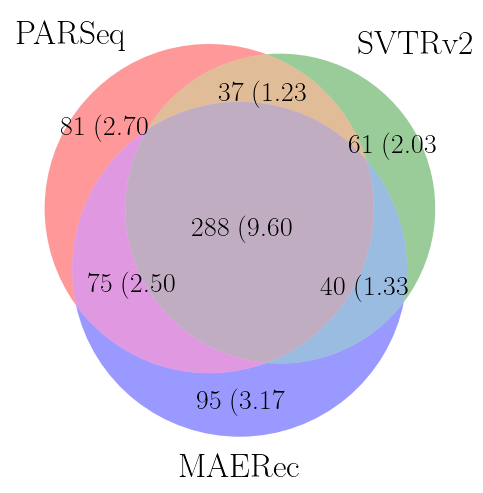

In [444]:
# Conjuntos de índices de erros
models_errors = {
    model.name: {result.path.stem for result in results if not result.eval()}
    for model, results in zip(
        [parseq_model, svtrv2_model, maerec_model],
        [parseq_results, svtrv2_results, maerec_results]
    )
}

# Diagrama de Venn para erros
plt.figure(figsize=(6,6))
v = venn.venn3(
    list(models_errors.values()),
    set_labels = list(models_errors.keys())
)

total = len(infer_items)

# Substituir contagens por percentuais
for idx in range(1, 8):
    label = v.get_label_by_id(bin(idx)[2:].zfill(3))
    if label:
        count = int(label.get_text())
        percent = 100 * count / total
        label.set_text(f"{count} ({percent:.2f}%)")

# Salvar como PDF
plt.savefig("venn-pretrained.pdf", format="pdf", bbox_inches="tight", pad_inches=0)

# Exibir o gráfico
plt.show()

## Teste do *ensemble*

### Execução do *ensemble*

In [478]:
infer_imgs, infer_items = define_inference("testB")

In [479]:
models = [
    # parseq_model,
    tuned_parseq_model,
    # svtrv2_model,
    tuned_svtrv2_model,
    # maerec_model,
    tuned_maerec_model
]

In [480]:
strategies = [
    EnsembleStrategy(
        strategy=min_weighted_confidence_voting_strategy,
    ),
    EnsembleStrategy(
        strategy=needleman_wunsch_strategy,
        filters=[
            min_length_filter(minimum_length=9),
        ],
    ),
    EnsembleStrategy(
        strategy=dictionary_correction_strategy,
        filters=[
            min_length_filter(minimum_length=9),
            min_confidence_filter(minimum_confidence=0.6),
        ],
    ),
]

In [481]:
ensemble = Ensemble(
    name="Ensemble",
    models=models,
    strategies=strategies
)

Modelos do ensemble:
	PARSeq (Com ajuste fino)
	SVTRv2 (Com ajuste fino)
	MAERec (Com ajuste fino)

Estratégias do ensemble:
	min_weighted_confidence_voting_strategy
	needleman_wunsch_strategy (1 filtro)
	dictionary_correction_strategy (2 filtros)


In [482]:
results = ensemble.run(infer_imgs, infer_items, verbose = True, should_output = True)

Ensemble: 100%|██████████| 3000/3000 [00:02<00:00, 1043.71it/s]



PARSeq tuned: 87.60% (2628/3000)
SVTRv2 tuned: 88.13% (2644/3000)
MAERec tuned: 87.50% (2625/3000)
Ensemble: 89.90% (2697/3000)


In [ ]:
# Ensemble: 89.90% (2697/3000)

### Análise de erros

In [841]:
# Função para mostrar predições do ensemble
def plot_ensemble_predictions(
        ensemble_preds: list[EnsemblePrediction],
        ncols: int,
        figsize: tuple[int, int],
        output_path: pathlib.Path,
        titles: list[str] = []
) -> None:
    n = len(ensemble_preds)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten() if n > 1 else [axes]

    def make_entry(name: str, pred: str, label: str, confidence: list[float] = []) -> str:
        conf_str = f" ({np.average(confidence):.2f})" if confidence else "~~~~~~~"

        pred_highlight = ""
        for i in range(max(len(pred), len(label))):
            p = pred[i] if i < len(pred) else ""
            l = label[i] if i < len(label) else ""
            if p == l:
                pred_highlight += p
            else:
                pred_highlight += r"\textcolor{red}{" + str(p) + r"}"

        return f"{name}:~{pred_highlight}{conf_str}"

    for i, ax in enumerate(axes):
        if i >= n:
            ax.axis("off")
            continue

        # Predição do ensemble
        ensemble_pred = ensemble_preds[i]

        # Carrega imagem
        img = PIL.Image.open(ensemble_pred.path).convert("RGBA")

        # Proporção da figura
        fig_aspect = (figsize[0] / ncols) / (figsize[1] / (nrows * 2))

        # Cria nova imagem transparente com proporção da figura
        fig_height = img.height
        fig_width = int(fig_height * fig_aspect)
        new_img = PIL.Image.new("RGBA", (fig_width, fig_height), (0, 0, 0, 0))

        # Redimensiona mantendo a proporção
        img_aspect = img.width / img.height
        if img_aspect > fig_aspect:
            new_w = fig_width
            new_h = int(fig_width / img_aspect)
        else:
            new_h = fig_height
            new_w = int(fig_height * img_aspect)
        resized_img = img.resize((new_w, new_h), Image.Resampling.LANCZOS)
        offset = ((fig_width - new_w) // 2, (fig_height - new_h) // 2)
        new_img.paste(resized_img, offset)

        # Converte imagem para array
        new_img_arr = np.array(new_img)
        ax.imshow(new_img_arr, extent=(0, 1, 0.3, 1), aspect="auto")

        if titles and i < len(titles):
            ax.set_title(titles[i], fontsize=10, pad=5)

        ax.axis("off")

        # Adiciona entradas dos modelos
        entries = []
        for model, model_pred in zip(models, ensemble_pred.models_preds):
            entries.append(
                make_entry(
                    model.name,
                    model_pred.pred,
                    ensemble_pred.true,
                    model_pred.confidence
                )
            )

        # Adiciona entrada do ensemble
        entries.append(
            make_entry(
                ensemble.name.upper(),
                ensemble_pred.pred,
                ensemble_pred.true,
                ensemble_pred.confidence
            )
        )

        # Adiciona entrada do rótulo
        entries.append(make_entry("LABEL", ensemble_pred.true, ensemble_pred.true))

        # Corrigindo por comprimento dos nomes
        len_names = [len(entry.split(":")[0]) for entry in entries]
        entries = [
            r"\text{" + ("~" * (max(len_names) - len_names[i] + 5)) + entry + "}"
            for i, entry in enumerate(entries)
        ]

        # Adiciona texto
        ax.text(
            0.38, -0.3,
            "\n\n" + "\n".join(entries),
            ha = "center",
            va = "center",
            fontsize = 10,
            family = "monospace",
            transform = ax.transAxes,
        )

    plt.tight_layout()
    plt.subplots_adjust(bottom = 0.2)
    plt.savefig(output_path, format = "pdf", bbox_inches = "tight", pad_inches = 0.3, backend = "pgf")
    plt.show()

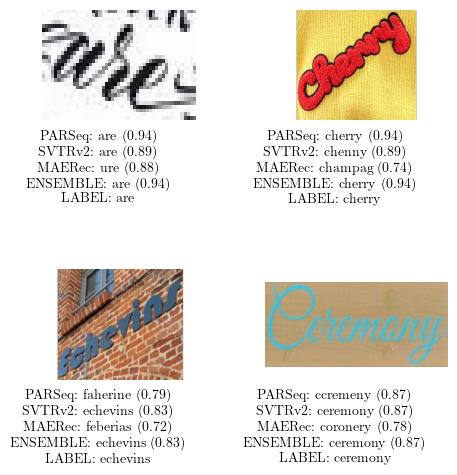

In [845]:
correct_results = [
    result
    for result in results
    if result.eval()
]

plot_ensemble_predictions(
    [
        correct_results[1],
        correct_results[1515],
        correct_results[2097],
        correct_results[2198]
    ],
    2,
    (5, 5),
    "results-correct.pdf"
)

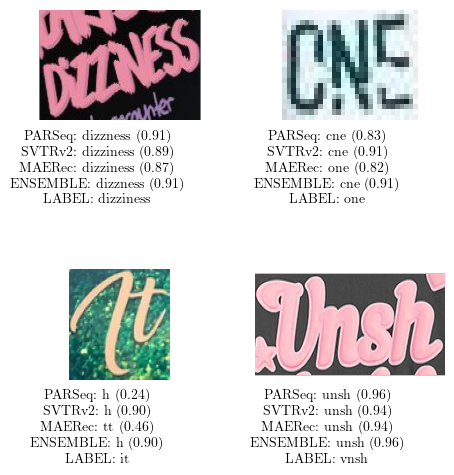

In [844]:
wrong_results = [
    result
    for result in results
    if not result.eval()
]

plot_ensemble_predictions(
    [
        wrong_results[40],
        wrong_results[47],
        wrong_results[118],
        wrong_results[251]
    ],
    2,
    (5, 5),
    "results-wrong.pdf"
)

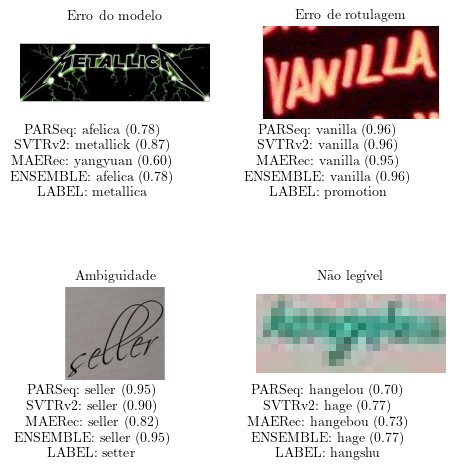

In [843]:
problem_imgs = ["new18859", "new16923", "new7773", "new16106"]
problem_types = ["Erro do modelo", "Erro de rotulagem", "Ambiguidade", "Não legível"]

problem_indexes = []
for problem_img in problem_imgs:
    for i, result in enumerate(results):
        if result.path.stem == problem_img:
            problem_indexes.append(i)

plot_ensemble_predictions(
    [
        results[i]
        for i in problem_indexes
    ],
    2,
    (5, 5),
    "results-problem.pdf",
    titles = problem_types
)